In [1]:
import os
import pandas as pd
from MulticoreTSNE import MulticoreTSNE as TSNE
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
!mkdir -p sandbox #let's put all stuff in the sandbox
os.chdir("sandbox")

### Download a toy dataset which is describled in

    "Detection of low-abundance bacterial strains in metagenomic datasets by eigengenome partitioning." 
    Nature biotechnology 33.10 (2015): 1053.

In [3]:
if not os.path.exists('lsaTestData.tar.gz'):
    !wget https://github.com/brian-cleary/LatentStrainAnalysis/raw/master/testData.tar.gz -O lsaTestData.tar.gz

--2019-01-24 20:18:43--  https://github.com/brian-cleary/LatentStrainAnalysis/raw/master/testData.tar.gz
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/brian-cleary/LatentStrainAnalysis/master/testData.tar.gz [following]
--2019-01-24 20:18:43--  https://raw.githubusercontent.com/brian-cleary/LatentStrainAnalysis/master/testData.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17790844 (17M) [application/octet-stream]
Saving to: ‘lsaTestData.tar.gz’

lsaTestData.tar.gz  100%[===================>]  16.97M  5.37MB/s    in 3.4s    

2019-01-24 20:18:47 (5.00 MB/s) - ‘lsaTestData.tar.gz’ saved [17790844/17790844]


In [5]:
!tar xf lsaTestData.tar.gz >  /dev/null  2>&1
!cat original_reads/SRR*.fastq > data.fastq

### convert fastq file to a seq file

In [6]:
!python ../../scripts/fastseq/fastqToSeq.py -i data.fastq -o data.seq

### encode  reads

In [3]:
!python ../../scripts/fastseq/hashSeq.py -i data.seq --hash lsh -o data.hash -k 15

2019-01-24 20:21:47,114 - hashSeq - INFO - start converting...
2019-01-24 20:21:47,114 - hashSeq - INFO - parameters: {'out_file': 'data.hash', 'f': <function f at 0x7f02074c5b18>, 'hash_fun': 'lsh', 'bucket': 20000000, 'batch_size': 100000, 'hash_size': 22, 'kmer_size': 15, 'n_thread': 7, 'in_file': 'data.seq'}
2019-01-24 20:21:47,114 - hashSeq - INFO - creating hash ...
100%|████████████████████████████████████████| 660/660 [00:01<00:00, 407.13it/s]
2019-01-24 20:21:48,778 - hashSeq - INFO - finish creating hash ...
100%|█████████████████████████████████| 100000/100000 [01:29<00:00, 1120.10it/s]
2019-01-24 20:23:23,446 - hashSeq - INFO - written 100000 lines
100%|█████████████████████████████████| 100000/100000 [01:34<00:00, 1057.42it/s]
2019-01-24 20:25:03,310 - hashSeq - INFO - written 200000 lines
100%|████████████████████████████████████████| 374/374 [00:00<00:00, 430.20it/s]
2019-01-24 20:25:04,314 - hashSeq - INFO - written 200374 lines
2019-01-24 20:25:04,314 - hashSeq - INFO 

### train a model

In [4]:
!../../fastseq skipgram -input data.hash -output model

Read 16M words
Number of words:  417165
Number of labels: 0
Progress: 100.0% words/sec/thread:   36280 lr:  0.000000 loss:  1.594164 ETA:   0h 0m% words/sec/thread:   36519 lr:  0.012067 loss:  1.783659 ETA:   0h 0m


### Now the model is trained.  To visualize it, first get vectors of reads

In [11]:
def read_embedding(fname):
    with open(fname) as fin:
        lines=list(fin)
    assert len(lines)>1
    first_line=lines[0]
    num_word, dim_vec = [int(u) for u in first_line.split(" ")]
    assert len(lines)==num_word+1
    ret ={}
    for line in lines[1:]:
        lst = line.strip().split(" ")
        assert len(lst)==dim_vec+1, line
        if lst[0]=='</s>': continue
        word = int(lst[0])
        vec = np.array([float(u) for u in lst[1:]])
        ret[word]=vec
    return ret,dim_vec

embedding,dim_vec = read_embedding("model.vec")
seqvectors = []
with open("data.hash") as fin:
    lines = list(fin)
for i,line in enumerate(lines):
    words = [int(u) for u in line.strip().split(" ")]
    vec = [embedding[u] for u in words if u in embedding]
    seqvectors.append(np.mean(vec,0) if len(vec)>0 else None)#np.zeros([dim_vec],dtype=np.float32))
    #if i>10: break    

### Next get the labels

In [16]:
seqs = pd.read_csv("data.seq",sep='\t', header=None, usecols=[0,1],index_col=0)
seqs.columns=['id']
seqs['is_spike']=seqs['id'].map(lambda u: u.startswith("Spike"))
seqs['vec']=seqvectors
seqs.drop('id',axis=1,inplace=True)
seqs=seqs[~seqs['vec'].isnull()]
seqs[seqs['is_spike']].head()

,is_spike,vec
0,,
10001,True,"[0.20901083720930236, 0.15879133023255815, -0...."
10002,True,"[-0.13977729186046522, -0.20089517674418603, 0..."
10003,True,"[0.11275851511627906, -0.12522697674418604, -0..."
10004,True,"[0.2775530279069768, -0.1323303697674418, -0.1..."
10005,True,"[0.10739388720930242, -0.0324119953488372, -0...."


### Now train TSNE

In [21]:
seqs=seqs.sample(10000,replace=False) #to speed up 

In [24]:
tsne = TSNE(n_components=2, perplexity=100, n_jobs=8)
X=np.array(list(seqs['vec'].values))
X.shape

(10000, 100)

In [25]:
%time Y = tsne.fit_transform(X)

CPU times: user 3min 39s, sys: 304 ms, total: 3min 39s
Wall time: 60 s


### visualization

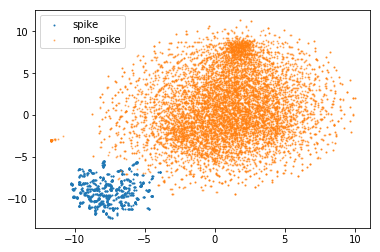

In [36]:
labels=seqs['is_spike'].values
plt.scatter(Y[labels][:,0],Y[labels][:,1],alpha=1,s=1)
plt.scatter(Y[~labels][:,0],Y[~labels][:,1],alpha=0.5,s=1)
plt.legend(['spike','non-spike'])